In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from PIL import Image 
import numpy as np
import os
import glob
import re
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# making sure I am running on GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # list of DeviceAttributes

import tensorflow as tf
tf.config.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12831483836671564058
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22723493888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15615367323949173630
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6"
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

## Data loading and Preprocessing

In [4]:
#dirs = os.listdir('/content/drive/My Drive/google_dataset/')
dirs = os.listdir('./UAV_Dataset/')
dirs

['0', '1']

In [5]:
def load_data(X,Y):
  label = 0
  for i in dirs:
    n = 0
    count = 0
    label = i
    for pic in glob.glob('./UAV_Dataset/'+i+'/*.jpg'):
      im = Image.open(pic)
      im = im.resize((512, 512))
      im = np.array(im)
      if((im.shape[0]==512) and (im.shape[1] == 512)):
        X.append(im)
        Y.append([label])
        n = n + 1
X=[]
Y=[]
load_data(X,Y)

In [6]:
img_rows = 512
img_cols = 512
num_class = 2

In [7]:
import numpy as np
x_bck=X
y_bck=Y

X =  np.array(X)
Y =  np.array(Y)
X = X.reshape(X.shape[0], img_rows, img_cols, 3)
X.shape

(1794, 512, 512, 3)

In [8]:
import tensorflow as tf
import tensorboard
tensorboard.__version__

'2.5.0'

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

input_shape = (img_rows, img_cols, 3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
#y_train = tf.keras.utils.to_categorical(y_train, 2)
#y_test = tf.keras.utils.to_categorical(y_test, 2)
y_train = y_train.flatten().astype('float32')
y_test = y_test.flatten().astype('float32')
print(X_train.shape)
print(X_test.shape)

(1435, 512, 512, 3)
(359, 512, 512, 3)


Visualization of Dataset

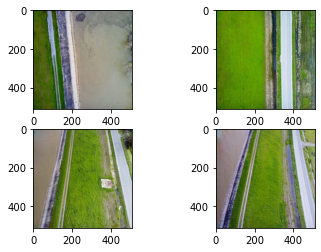

In [10]:
fig=plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(X_train[i].reshape(512,512,3))

# DCT and preprocessing

In [11]:
import time 
import cv2 
from scipy.fftpack import dct 

a=[]
b=[]
#y = np.random.random((5000, 6, 6, 3))
t1 = time.time()
a = np.zeros((len(X_train), 512, 512, 3))
b = np.zeros((len(X_test), 512, 512, 3))
for i in range(len(X_train)):
    for j in range(3):
        a[i, : , : , j] = cv2.dct(X_train[i, : , : , j])
        np.transpose(a, [0, 2, 1, 3])

for i in range(len(X_train)):
    for j in range(3):
        a[i, :, :, j] = cv2.dct(X_train[i, :, :, j]) 

for i in range(0,len(X_test)):
    for j in range(3):
        b[i, : , : , j] = cv2.dct(X_test[i, : , : , j])
        np.transpose(b, [0, 2, 1, 3])

for i in range(len(X_test)):
    for j in range(3):
        b[i, :, :, j] = cv2.dct(X_test[i, :, :, j]) 
 


In [12]:
# Clear any logs from previous runs
!rm -rf ./logs/

N_ARY

In [13]:
a_cut = a[:,:64,:64,:]
b_cut = b[:,:64,:64,:]

In [14]:
a_ary = a_cut.reshape((X_train.shape[0],4096,3))
b_ary = b_cut.reshape((X_test.shape[0],4096,3))

In [15]:
a_ary_bckp=a_ary
b_aray_bcp=b_ary

In [16]:
print(a_ary.shape)
a_ary[0]

(1435, 4096, 3)


array([[ 2.52661652e+02,  2.66778137e+02,  2.22532028e+02],
       [-5.41872787e+01, -3.86206474e+01, -6.85516586e+01],
       [-4.30237389e+01, -2.57323704e+01, -5.84657745e+01],
       ...,
       [ 2.72940814e-01,  2.01094002e-01,  2.59379774e-01],
       [ 1.54709622e-01,  6.31975606e-02,  1.67623952e-01],
       [ 1.72977209e-01,  1.11568414e-01,  2.01978251e-01]])

In [17]:
final_a_ary = np.zeros((a_ary.shape[0],4098,3))
final_b_ary = np.zeros((b_ary.shape[0],4098,3))

In [18]:
n = 2                                            
mul=int(a_ary.shape[1])/n
avgs = []
count=0

for j in range(a_ary.shape[0]):
    avgR = []
    avgG = []
    avgB = []
    for i in range(n):
        l = int(mul*i)
        lend = int(mul*(i+1) - 1)
        np.sort(a_ary[j,:,0])
        np.sort(a_ary[j,:,1])
        np.sort(a_ary[j,:,2])
        avgR.append(np.average(a_ary[j,l:lend,0]))
        avgG.append(np.average(a_ary[j,l:lend,1]))
        avgB.append(np.average(a_ary[j,l:lend,2]))
    avgR = np.array(avgR)
    avgG = np.array(avgG)
    avgB = np.array(avgB)
    final_a_ary[j,:,0] = np.concatenate((a_ary[j,:,0],avgR))
    final_a_ary[j,:,1] = np.concatenate((a_ary[j,:,1],avgG))
    final_a_ary[j,:,2] = np.concatenate((a_ary[j,:,2],avgB))

mul=int(b_ary.shape[1])/n

for j in range(b_ary.shape[0]):
    avgR = []
    avgG = []
    avgB = []
    for i in range(n):
        l = int(mul*i)
        lend = int(mul*(i+1) - 1)
        np.sort(b_ary[j,:,0])
        np.sort(b_ary[j,:,1])
        np.sort(b_ary[j,:,2])
        avgR.append(np.average(b_ary[j,l:lend,0]))
        avgG.append(np.average(b_ary[j,l:lend,1]))
        avgB.append(np.average(b_ary[j,l:lend,2]))
    avgR = np.array(avgR)
    avgG = np.array(avgG)
    avgB = np.array(avgB)
    final_b_ary[j,:,0] = np.concatenate((b_ary[j,:,0],avgR))
    final_b_ary[j,:,1] = np.concatenate((b_ary[j,:,1],avgG))
    final_b_ary[j,:,2] = np.concatenate((b_ary[j,:,2],avgB))

In [19]:
final_a_ary.shape

(1435, 4098, 3)

In [20]:
final_b_ary.shape

(359, 4098, 3)

# Modeling

In [21]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, MaxPooling1D,Embedding
from keras.datasets import imdb
from tensorflow.keras.utils import plot_model
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
# Graphic output
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [22]:
import datetime
print(datetime.__file__)
datetime.time()

C:\Users\VENUM\anaconda3\envs\tf-gpu\lib\datetime.py


datetime.time(0, 0)

In [23]:
logdir="logs/fit/" + "model1"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# 1DCNN ON MATRIX MIX

In [24]:
model1dM = Sequential()
model1dM.add(Conv1D(32, kernel_size=5, input_shape = (4098, 3)))
model1dM.add(Conv1D(32, kernel_size=5))    # added new
model1dM.add(MaxPooling1D(pool_size=(2)))
model1dM.add(Conv1D(64, kernel_size=5))
model1dM.add(Conv1D(64, kernel_size=5))    # added new
model1dM.add(MaxPooling1D(pool_size=(2)))
model1dM.add(Conv1D(128, kernel_size=3))
model1dM.add(Conv1D(128, kernel_size=3))    # added new and changed to 128 from 64
model1dM.add(MaxPooling1D(pool_size=(2)))
model1dM.add(Dropout(0.25))
model1dM.add(Flatten())
model1dM.add(Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(l=0.1)))
model1dM.add(Dropout(0.5))
model1dM.add(Dense(1, activation='sigmoid'))
model1dM.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [25]:
model1dM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4094, 32)          512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4090, 32)          5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2045, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2041, 64)          10304     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2037, 64)          20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1018, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1016, 128)         2

In [26]:
model1dM.fit(final_a_ary, y_train, batch_size=50, epochs=50, verbose=1, validation_data=(final_b_ary, y_test),callbacks=[tensorboard_callback])

Epoch 1/50
29/29 [==============================] - 14s 49ms/step - loss: 13.1591 - accuracy: 0.5325 - val_loss: 2.2146 - val_accuracy: 0.6462
Epoch 2/50
29/29 [==============================] - 0s 17ms/step - loss: 1.6476 - accuracy: 0.7753 - val_loss: 0.8851 - val_accuracy: 0.8078
Epoch 3/50
29/29 [==============================] - 0s 17ms/step - loss: 0.7373 - accuracy: 0.8436 - val_loss: 0.7365 - val_accuracy: 0.8524
Epoch 4/50
29/29 [==============================] - 0s 17ms/step - loss: 0.6029 - accuracy: 0.9000 - val_loss: 0.7396 - val_accuracy: 0.8468
Epoch 5/50
29/29 [==============================] - 0s 17ms/step - loss: 0.6260 - accuracy: 0.8983 - val_loss: 0.9560 - val_accuracy: 0.7716
Epoch 6/50
29/29 [==============================] - 0s 17ms/step - loss: 0.7971 - accuracy: 0.8572 - val_loss: 1.0276 - val_accuracy: 0.7827
Epoch 7/50
29/29 [==============================] - 0s 17ms/step - loss: 0.6744 - accuracy: 0.9084 - val_loss: 0.7484 - val_accuracy: 0.8914
Epoch 8/50


In [27]:
loss, acc = model1dM.evaluate(final_b_ary, y_test, verbose=0)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))


Testing loss: 1.2644665241241455, acc: 0.89415043592453



In [30]:
#Cross validation
from sklearn.model_selection import StratifiedKFold
import logging

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
bigx = np.concatenate((final_a_ary,final_b_ary))
bigy = np.concatenate((y_train, y_test))
cvscores = []

# set logger level to ERROR to avoid repeated warnings from calling model metrics
tf.get_logger().setLevel(logging.ERROR)


for train, test in kfold.split(bigx, bigy):
    
    # create model
    model1dM.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
    
    # Fit the model
    model1dM.fit(bigx[train], bigy[train], epochs=10, verbose=0)
    
    # evaluate the model
    scores = model1dM.evaluate(bigx[test], bigy[test], verbose=0)
    print("%s: %.2f%%" % (model1dM.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

    # use the model to predict y values for this fold's test x
    pred = model1dM.predict(bigx[test])

    # calculate false positives and negatives based on the predicted output vs. expected output
    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(bigy[test], pred)
    fn = tf.keras.metrics.FalseNegatives()
    fn.update_state(bigy[test], pred)
    
    print('false positives', fp.result().numpy())
    print('false negatives', fn.result().numpy())
    print()
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


# calculate false positives and negatives based on the predicted output vs. expected output
fp = tf.keras.metrics.FalsePositives()
fp.update_state(bigy[test], pred)
fp = fp.result().numpy()
# Getting False Negative
fn = tf.keras.metrics.FalseNegatives()
fn.update_state(bigy[test], pred)
fn = fn.result().numpy()
# Getting True Negative
tn = tf.keras.metrics.TrueNegatives()
tn.update_state(bigy[test], pred)
tn = tn.result().numpy()
#Calculating True Negative 
# Find false positive rate.
fpr = fp / (fp + tn)


#calculating True Positve
tp = tf.keras.metrics.TruePositives()
tp.update_state(bigy[test], pred)
tp = tp.result().numpy()
#code for false negative 
fnr = fn / (fn + tp)


print("False Negative Rate", fnr)
print("Value of FPR", fpr)

accuracy: 99.44%
99.44% (+/- 0.00%)
false positives 2.0
false negatives 0.0

accuracy: 98.05%
98.75% (+/- 0.70%)
false positives 1.0
false negatives 6.0

accuracy: 100.00%
99.16% (+/- 0.82%)
false positives 0.0
false negatives 0.0

accuracy: 94.99%
98.12% (+/- 1.94%)
false positives 15.0
false negatives 3.0

accuracy: 96.65%
97.83% (+/- 1.84%)
false positives 10.0
false negatives 2.0

97.83% (+/- 1.84%)
False Negative Rate 0.01724138
Value of FPR 0.041322313


accuracy:  0.9888579387186629
precision:  0.9699248120300752
recall:  1.0
f1:  0.9847328244274809
False Negative Rate 0.01724138
Value of FPR 0.041322313


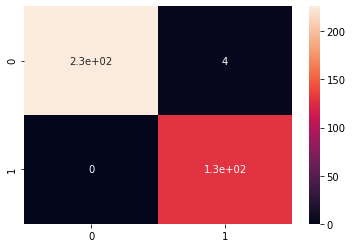

In [31]:
# For Hamza : this FPR & FNR should be different than line 30

# predict y from the test x
y_pred=model1dM.predict(final_b_ary)

# calculate predicted and actual labels (threshold of .5 because binary classification)
y_pred_cats=y_pred>.5
y_test_cats=y_test>.5
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score,accuracy_score,confusion_matrix
import seaborn as sns


# calculate scores
accuracy=accuracy_score(y_test_cats,y_pred_cats)
precision=precision_score(y_test_cats,y_pred_cats)
recall=recall_score(y_test_cats,y_pred_cats)
f1=f1_score(y_test_cats,y_pred_cats)


print('accuracy: ',accuracy)
print('precision: ',precision)
print('recall: ',recall)
print('f1: ',f1)


cm=confusion_matrix(y_test_cats,y_pred_cats)
sns.heatmap(cm,annot=True)

# calculate false positives
#fp = tf.keras.metrics.FalsePositives()
#fp.update_state(y_test, model1dM.predict(final_b_ary))

# calculate false negatives
#fn = tf.keras.metrics.FalseNegatives()
#fn.update_state(y_test, model1dM.predict(final_b_ary))

#print('false positives', fp.result().numpy())
#print('false negatives', fn.result().numpy())

# calculate false positives and negatives based on the predicted output vs. expected output
fp = tf.keras.metrics.FalsePositives()
fp.update_state(bigy[test], pred)
fp = fp.result().numpy()
# Getting False Negative
fn = tf.keras.metrics.FalseNegatives()
fn.update_state(bigy[test], pred)
fn = fn.result().numpy()
# Getting True Negative
tn = tf.keras.metrics.TrueNegatives()
tn.update_state(bigy[test], pred)
tn = tn.result().numpy()
#Calculating True Negative 
# Find false positive rate.
fpr = fp / (fp + tn)


#calculating True Positve
tp = tf.keras.metrics.TruePositives()
tp.update_state(bigy[test], pred)
tp = tp.result().numpy()
#code for false negative 
fnr = fn / (fn + tp)


print("False Negative Rate", fnr)
print("Value of FPR", fpr)

In [32]:
#tf.keras.utils.plot_model(model1dM,to_file="model.png")

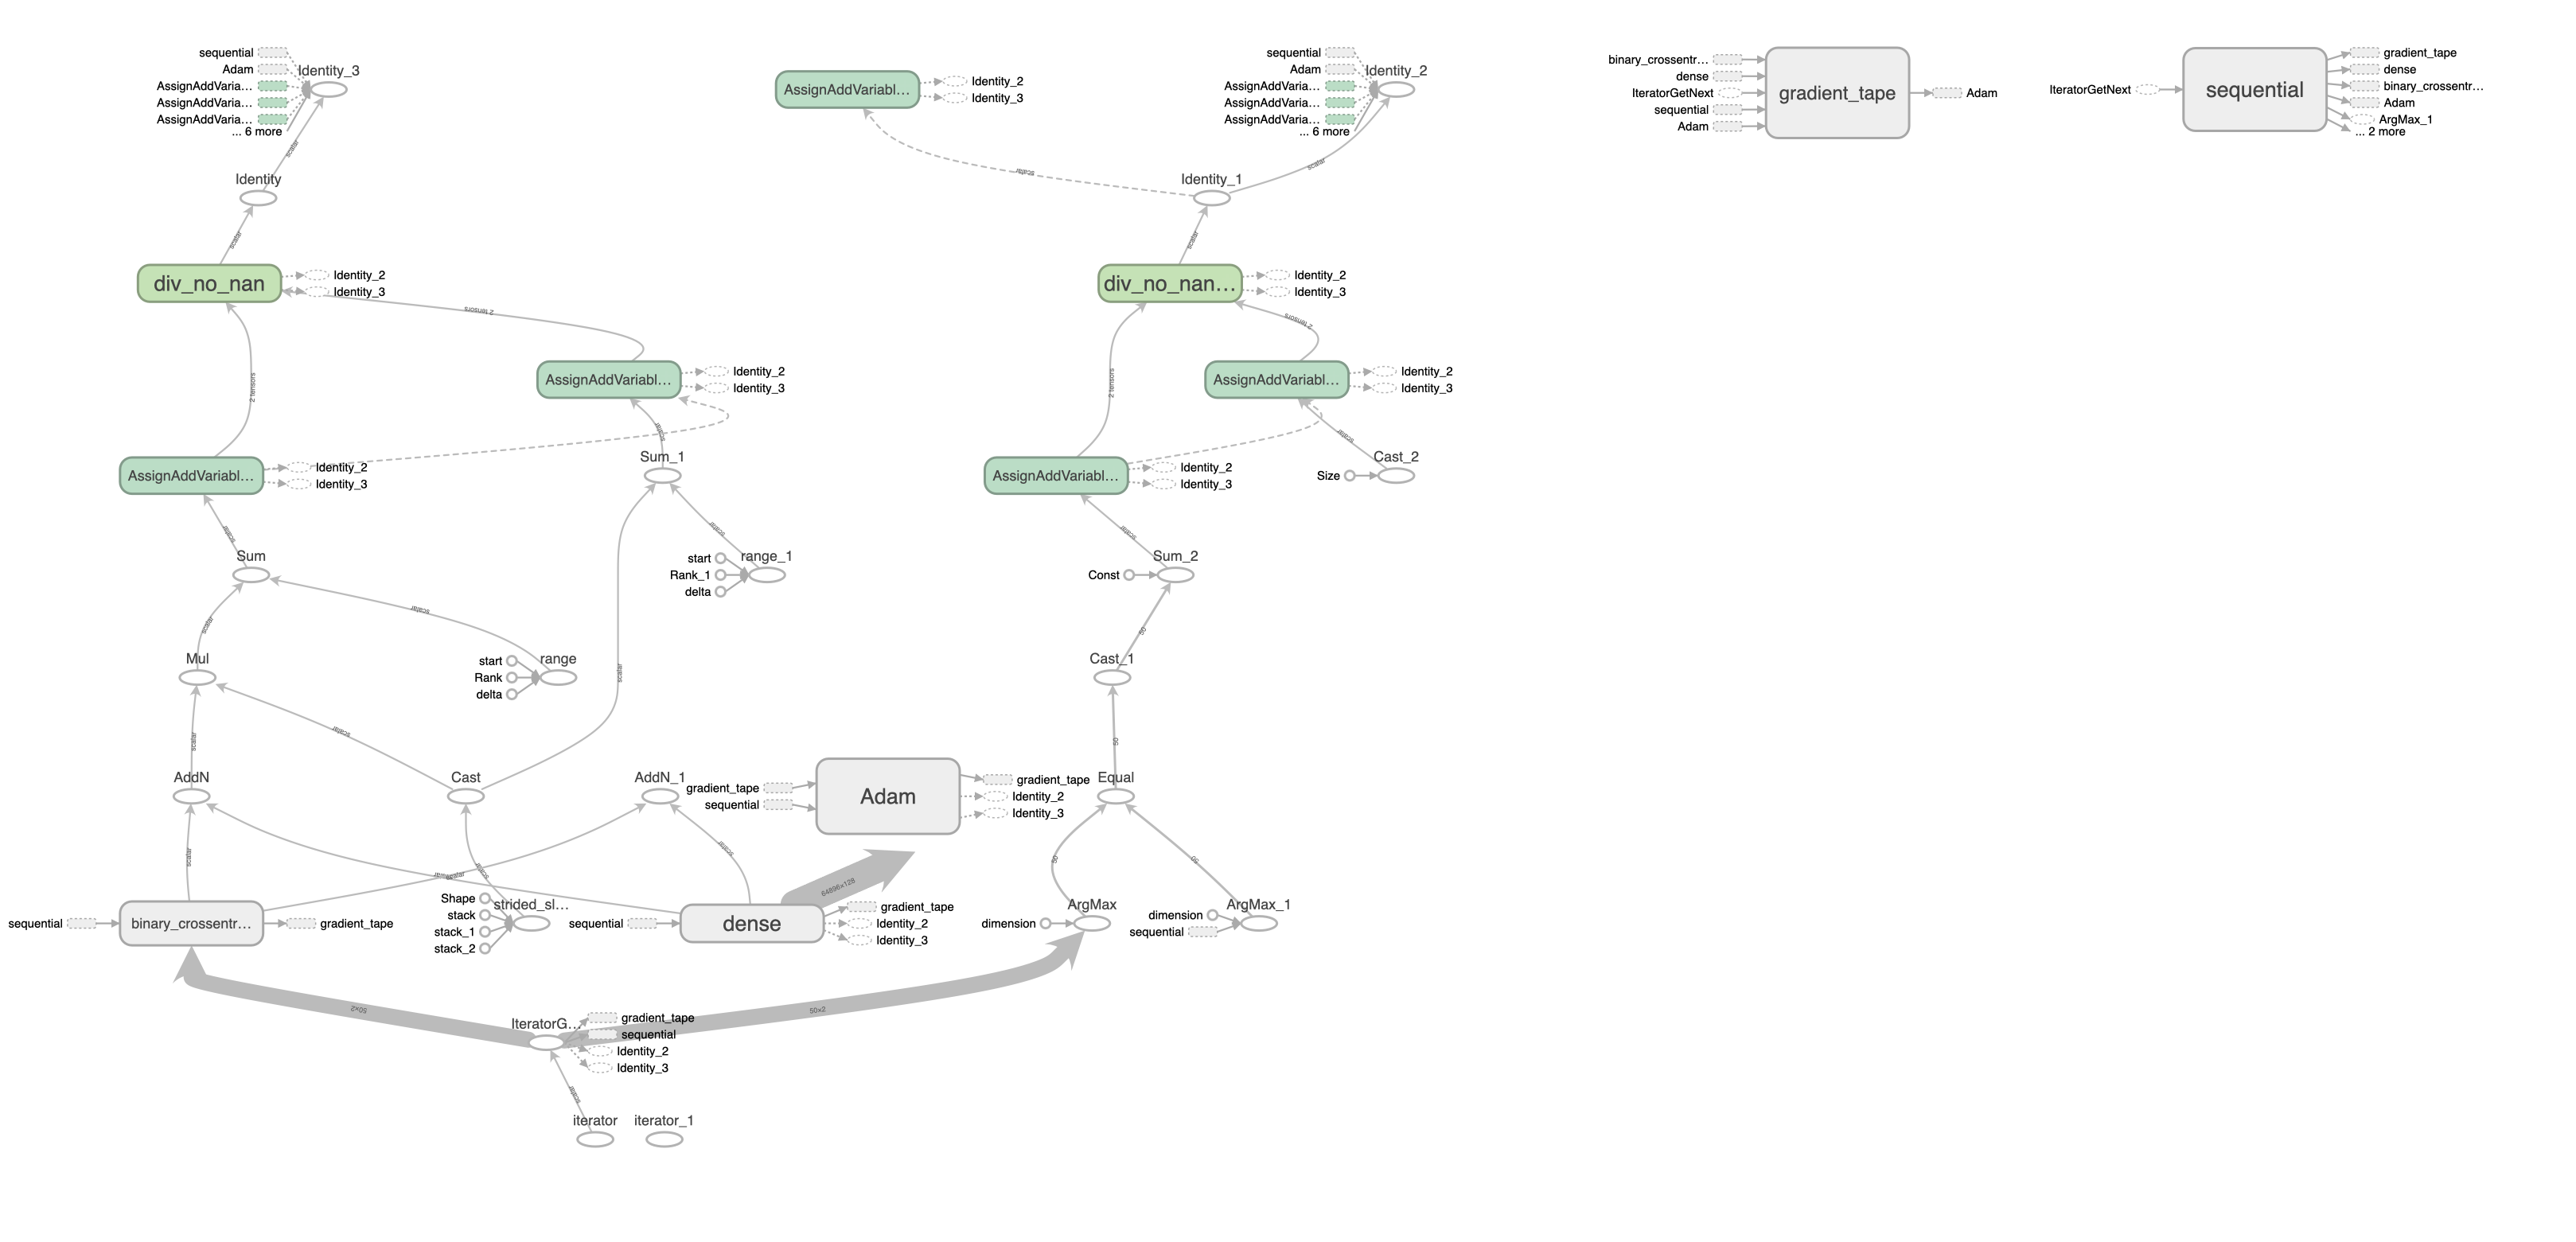

# BATCH NORMALIZATION ON CONCATED MATRIX

In [33]:
logdir="logs/fit/" + 'model2'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
from keras.layers.normalization import BatchNormalization

# instantiate model
modelBNM = Sequential()
modelBNM.add(Conv1D(32, kernel_size=5, input_shape = (4098, 3)))
modelBNM.add(MaxPooling1D(pool_size=(2)))
modelBNM.add(Conv1D(32, kernel_size=5))
modelBNM.add(MaxPooling1D(pool_size=(2)))
modelBNM.add(Conv1D(64, kernel_size=3))
modelBNM.add(MaxPooling1D(pool_size=(2)))
modelBNM.add(Dropout(0.25))
modelBNM.add(Flatten())
# we can think of this chunk as the input layer
modelBNM.add(Dense(128))
modelBNM.add(BatchNormalization())
modelBNM.add(Activation('relu'))
modelBNM.add(Dropout(0.5))

# we can think of this chunk as the hidden layer    
modelBNM.add(Dense(64))
modelBNM.add(BatchNormalization())
modelBNM.add(Activation('relu'))
modelBNM.add(Dropout(0.5))

# we can think of this chunk as the output layer
modelBNM.add(Dense(1))
modelBNM.add(BatchNormalization())
modelBNM.add(Activation('sigmoid'))

# setting up the optimization of our weights 
#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
modelBNM.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# running the fitting


In [35]:
modelBNM.fit(final_a_ary, y_train, batch_size=50, epochs=50, verbose=1, validation_data=(final_b_ary, y_test),callbacks=[tensorboard_callback])

Epoch 1/50
29/29 [==============================] - 26s 824ms/step - loss: 0.6672 - accuracy: 0.6119 - val_loss: 5.3324 - val_accuracy: 0.3621
Epoch 2/50
29/29 [==============================] - 0s 15ms/step - loss: 0.5086 - accuracy: 0.7876 - val_loss: 1.7994 - val_accuracy: 0.3955
Epoch 3/50
29/29 [==============================] - 0s 15ms/step - loss: 0.4719 - accuracy: 0.8453 - val_loss: 0.3926 - val_accuracy: 0.8691
Epoch 4/50
29/29 [==============================] - 0s 15ms/step - loss: 0.4292 - accuracy: 0.9028 - val_loss: 0.3949 - val_accuracy: 0.8496
Epoch 5/50
29/29 [==============================] - 0s 15ms/step - loss: 0.3868 - accuracy: 0.9416 - val_loss: 0.3788 - val_accuracy: 0.9053
Epoch 6/50
29/29 [==============================] - 0s 15ms/step - loss: 0.3664 - accuracy: 0.9540 - val_loss: 0.4179 - val_accuracy: 0.8802
Epoch 7/50
29/29 [==============================] - 0s 15ms/step - loss: 0.3396 - accuracy: 0.9736 - val_loss: 0.4684 - val_accuracy: 0.7632
Epoch 8/50


In [36]:
loss, acc = modelBNM.evaluate(final_b_ary, y_test, verbose=0)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))


Testing loss: 0.3583909273147583, acc: 0.8579387068748474



In [37]:
from sklearn.model_selection import StratifiedKFold
import logging

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
bigx = np.concatenate((final_a_ary,final_b_ary))
bigy = np.concatenate((y_train, y_test))
cvscores = []
tf.get_logger().setLevel(logging.ERROR)
for train, test in kfold.split(bigx, bigy):
    # create model
    modelBNM.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
    # Fit the model
    #print(train)
    modelBNM.fit(bigx[train], bigy[train], epochs=10, verbose=0)
    # evaluate the model
    scores = modelBNM.evaluate(bigx[test], bigy[test], verbose=0)
    print("%s: %.2f%%" % (modelBNM.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

    pred = modelBNM.predict(bigx[test])

    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(bigy[test], pred)
    fn = tf.keras.metrics.FalseNegatives()
    fn.update_state(bigy[test], pred)
    
    print('false positives', fp.result().numpy())
    print('false negatives', fn.result().numpy())
    print()
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


# calculate false positives and negatives based on the predicted output vs. expected output
fp = tf.keras.metrics.FalsePositives()
fp.update_state(bigy[test], pred)
fp = fp.result().numpy()
# Getting False Negative
fn = tf.keras.metrics.FalseNegatives()
fn.update_state(bigy[test], pred)
fn = fn.result().numpy()
# Getting True Negative
tn = tf.keras.metrics.TrueNegatives()
tn.update_state(bigy[test], pred)
tn = tn.result().numpy()
#Calculating True Negative 
# Find false positive rate.
fpr = fp / (fp + tn)


#calculating True Positve
tp = tf.keras.metrics.TruePositives()
tp.update_state(bigy[test], pred)
tp = tp.result().numpy()
#code for false negative 
fnr = fn / (fn + tp)


print("False Negative Rate", fnr)
print("Value of FPR", fpr)

accuracy: 98.89%
98.89% (+/- 0.00%)
false positives 0.0
false negatives 4.0

accuracy: 99.16%
99.03% (+/- 0.14%)
false positives 0.0
false negatives 3.0

accuracy: 99.72%
99.26% (+/- 0.35%)
false positives 0.0
false negatives 1.0

accuracy: 99.16%
99.23% (+/- 0.30%)
false positives 1.0
false negatives 2.0

accuracy: 100.00%
99.39% (+/- 0.41%)
false positives 0.0
false negatives 0.0

99.39% (+/- 0.41%)
False Negative Rate 0.0
Value of FPR 0.0


accuracy:  0.9972144846796658
precision:  1.0
recall:  0.9922480620155039
f1:  0.9961089494163424
False Negative Rate 0.0
Value of FPR 0.0


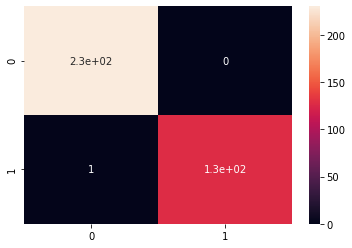

In [38]:
# For Hamza : this FPR & FNR should be different than line 37 also this should not be 0.0

y_pred=modelBNM.predict(final_b_ary)
# y_pred_cats=y_pred.argmax(axis=1)
# y_test_cats=y_test.argmax(axis=1)
y_pred_cats=y_pred>.5
y_test_cats=y_test>.5
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score,accuracy_score
import seaborn as sns
#y_pred=modelBNrm.predict(final_b_ary)
accuracy=accuracy_score(y_test_cats,y_pred_cats)
precision=precision_score(y_test_cats,y_pred_cats)
recall=recall_score(y_test_cats,y_pred_cats)
f1=f1_score(y_test_cats,y_pred_cats)
print('accuracy: ',accuracy)
print('precision: ',precision)
print('recall: ',recall)
print('f1: ',f1)
cm=confusion_matrix(y_test_cats,y_pred_cats)
sns.heatmap(cm,annot=True)

#fp = tf.keras.metrics.FalsePositives()
#fp.update_state(y_test, modelBNM.predict(final_b_ary))
#fn = tf.keras.metrics.FalseNegatives()
#fn.update_state(y_test, modelBNM.predict(final_b_ary))
#print('false positives', fp.result().numpy())
#print('false negatives', fn.result().numpy())


# calculate false positives and negatives based on the predicted output vs. expected output
fp = tf.keras.metrics.FalsePositives()
fp.update_state(bigy[test], pred)
fp = fp.result().numpy()
# Getting False Negative
fn = tf.keras.metrics.FalseNegatives()
fn.update_state(bigy[test], pred)
fn = fn.result().numpy()

# Getting True Negative
tn = tf.keras.metrics.TrueNegatives()
tn.update_state(bigy[test], pred)
tn = tn.result().numpy()

#Calculating True Negative 
# Find false positive rate.
fpr = fp / (fp + tn)


#calculating True Positve
tp = tf.keras.metrics.TruePositives()
tp.update_state(bigy[test], pred)
tp = tp.result().numpy()
#code for false negative 
fnr = fn / (fn + tp)


print("False Negative Rate", fnr)
print("Value of FPR", fpr)

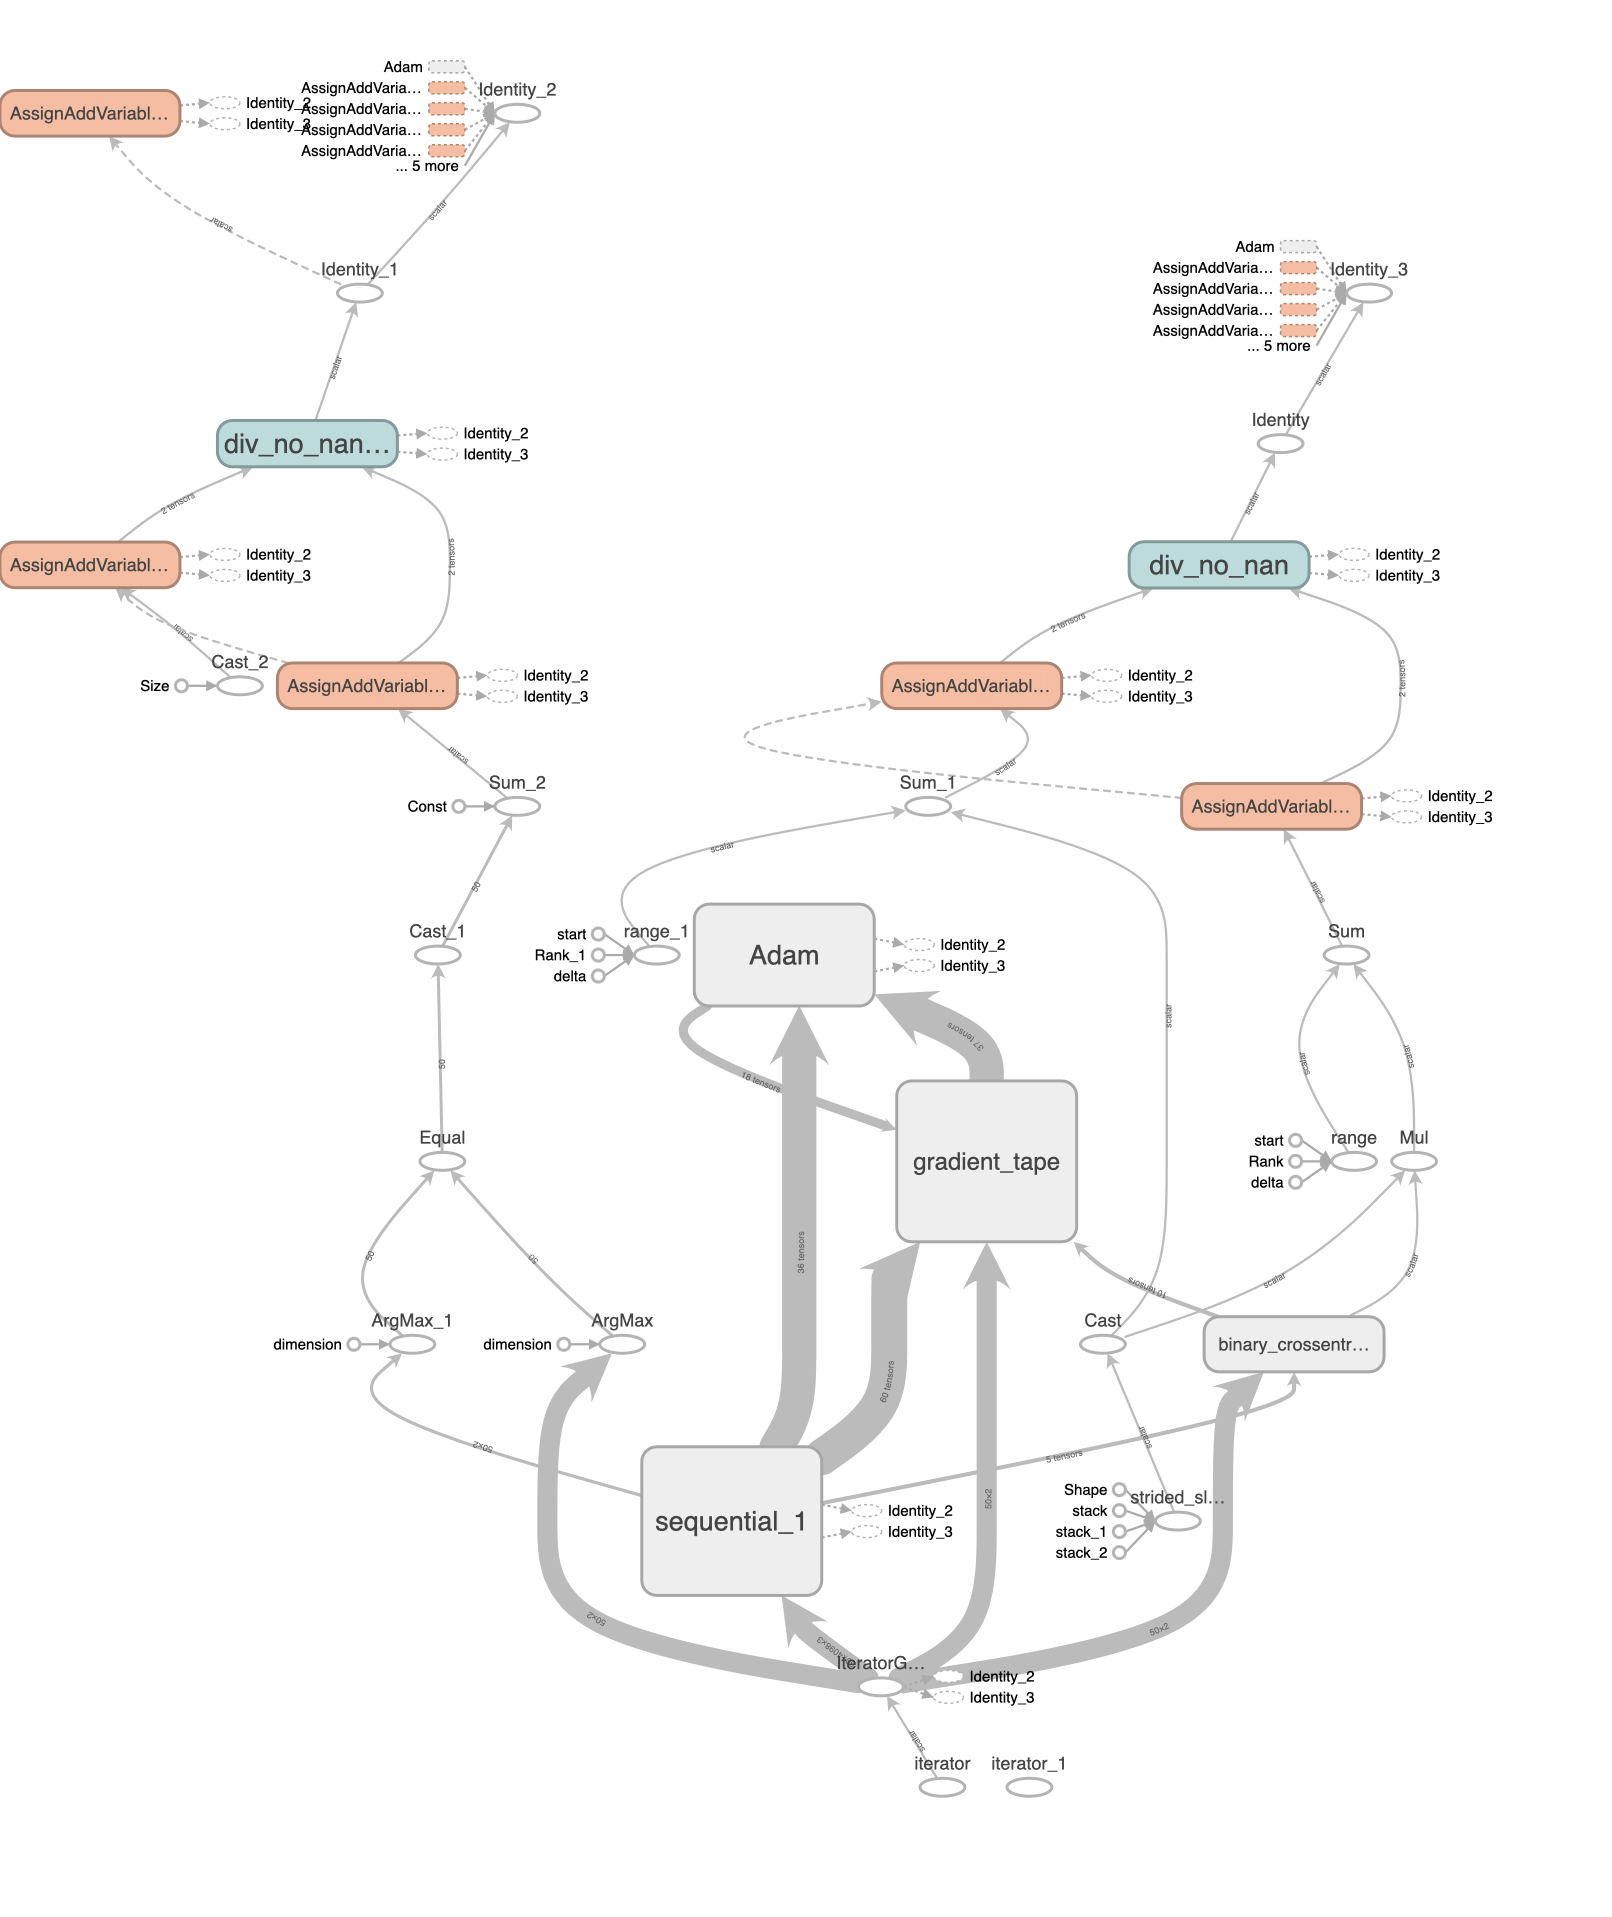

# BN WITH REGULARIZATION 

In [39]:
logdir="logs/fit/" + "model3"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [40]:
from keras.layers.normalization import BatchNormalization

# instantiate model
modelBNrm = Sequential()
modelBNrm.add(Conv1D(32, kernel_size=5, input_shape = (4098, 3)))
modelBNrm.add(MaxPooling1D(pool_size=(2)))
modelBNrm.add(Conv1D(32, kernel_size=5))
modelBNrm.add(MaxPooling1D(pool_size=(2)))
modelBNrm.add(Conv1D(64, kernel_size=3))
modelBNrm.add(MaxPooling1D(pool_size=(2)))
modelBNrm.add(Dropout(0.25))
modelBNrm.add(Flatten())
# we can think of this chunk as the input layer
modelBNrm.add(Dense(128,kernel_regularizer=keras.regularizers.l2(l=0.1)))
modelBNrm.add(BatchNormalization())
modelBNrm.add(Activation('relu'))
modelBNrm.add(Dropout(0.5))

# we can think of this chunk as the hidden layer    
modelBNrm.add(Dense(64,kernel_regularizer=keras.regularizers.l2(l=0.1)))
modelBNrm.add(BatchNormalization())
modelBNrm.add(Activation('relu'))
modelBNrm.add(Dropout(0.5))

# we can think of this chunk as the output layer
modelBNrm.add(Dense(1,kernel_regularizer=keras.regularizers.l2(l=0.1)))
modelBNrm.add(BatchNormalization())
modelBNrm.add(Activation('sigmoid'))

# setting up the optimization of our weights 
#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
modelBNrm.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# running the fitting


In [41]:
modelBNrm.fit(final_a_ary, y_train, batch_size=50, epochs=50, verbose=1, validation_data=(final_b_ary, y_test),callbacks=[tensorboard_callback])

Epoch 1/50
29/29 [==============================] - 12s 351ms/step - loss: 20.3368 - accuracy: 0.5964 - val_loss: 7.9142 - val_accuracy: 0.3705
Epoch 2/50
29/29 [==============================] - 0s 15ms/step - loss: 6.2685 - accuracy: 0.7146 - val_loss: 4.3789 - val_accuracy: 0.6323
Epoch 3/50
29/29 [==============================] - 0s 16ms/step - loss: 3.8412 - accuracy: 0.7959 - val_loss: 2.8290 - val_accuracy: 0.7660
Epoch 4/50
29/29 [==============================] - 0s 16ms/step - loss: 2.4671 - accuracy: 0.8688 - val_loss: 1.9805 - val_accuracy: 0.7019
Epoch 5/50
29/29 [==============================] - 0s 16ms/step - loss: 1.7109 - accuracy: 0.8995 - val_loss: 1.5178 - val_accuracy: 0.7883
Epoch 6/50
29/29 [==============================] - 0s 16ms/step - loss: 1.2372 - accuracy: 0.9234 - val_loss: 1.2169 - val_accuracy: 0.8384
Epoch 7/50
29/29 [==============================] - 0s 15ms/step - loss: 0.9843 - accuracy: 0.9169 - val_loss: 1.0665 - val_accuracy: 0.7883
Epoch 8/50

In [42]:
loss, acc = modelBNrm.evaluate(final_b_ary, y_test, verbose=0)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))


Testing loss: 0.6934590935707092, acc: 0.8913649320602417



In [43]:
#Cross validation
from sklearn.model_selection import StratifiedKFold
import logging

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
bigx = np.concatenate((final_a_ary,final_b_ary))
bigy = np.concatenate((y_train, y_test))
cvscores = []
tf.get_logger().setLevel(logging.ERROR)
for train, test in kfold.split(bigx, bigy):
    # create model
    modelBNrm.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
    # Fit the model
    #print(train)
    modelBNrm.fit(bigx[train], bigy[train], epochs=10, verbose=0)
    # evaluate the model
    scores = modelBNrm.evaluate(bigx[test], bigy[test], verbose=0)
    print("%s: %.2f%%" % (modelBNrm.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

    pred = modelBNrm.predict(bigx[test])

    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(bigy[test], pred)
    fn = tf.keras.metrics.FalseNegatives()
    fn.update_state(bigy[test], pred)
    
    print('false positives', fp.result().numpy())
    print('false negatives', fn.result().numpy())
    print()
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


# calculate false positives and negatives based on the predicted output vs. expected output
fp = tf.keras.metrics.FalsePositives()
fp.update_state(bigy[test], pred)
fp = fp.result().numpy()
# Getting False Negative
fn = tf.keras.metrics.FalseNegatives()
fn.update_state(bigy[test], pred)
fn = fn.result().numpy()
# Getting True Negative
tn = tf.keras.metrics.TrueNegatives()
tn.update_state(bigy[test], pred)
tn = tn.result().numpy()
#Calculating True Negative 
# Find false positive rate.
fpr = fp / (fp + tn)


#calculating True Positve
tp = tf.keras.metrics.TruePositives()
tp.update_state(bigy[test], pred)
tp = tp.result().numpy()
#code for false negative 
fnr = fn / (fn + tp)


print("False Negative Rate", fnr)
print("Value of FPR", fpr)

accuracy: 96.94%
96.94% (+/- 0.00%)
false positives 4.0
false negatives 7.0

accuracy: 72.98%
84.96% (+/- 11.98%)
false positives 96.0
false negatives 1.0

accuracy: 96.38%
88.77% (+/- 11.16%)
false positives 6.0
false negatives 7.0

accuracy: 98.05%
91.09% (+/- 10.47%)
false positives 7.0
false negatives 0.0

accuracy: 66.20%
86.11% (+/- 13.67%)
false positives 121.0
false negatives 0.0

86.11% (+/- 13.67%)
False Negative Rate 0.0
Value of FPR 0.5


accuracy:  0.7270194986072424
precision:  0.5682819383259912
recall:  1.0
f1:  0.7247191011235955
False Negative Rate 0.0
Value of FPR 0.5


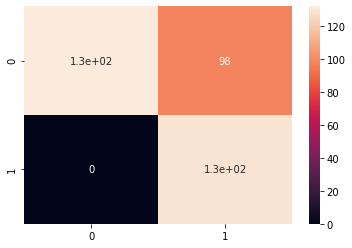

In [44]:
# For Hamza : this FPR & FNR should be different than line 43

y_pred=modelBNrm.predict(final_b_ary)
y_pred_cats=y_pred>.5
y_test_cats=y_test>.5
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score,accuracy_score,confusion_matrix
import seaborn as sns
#y_pred=modelBNrm.predict(final_b_ary)
accuracy=accuracy_score(y_test_cats,y_pred_cats)
precision=precision_score(y_test_cats,y_pred_cats)
recall=recall_score(y_test_cats,y_pred_cats)
f1=f1_score(y_test_cats,y_pred_cats)
print('accuracy: ',accuracy)
print('precision: ',precision)
print('recall: ',recall)
print('f1: ',f1)
cm=confusion_matrix(y_test_cats,y_pred_cats)
sns.heatmap(cm,annot=True)

#fp = tf.keras.metrics.FalsePositives()
#fp.update_state(y_test, modelBNrm.predict(final_b_ary))
#fn = tf.keras.metrics.FalseNegatives()
#fn.update_state(y_test, modelBNrm.predict(final_b_ary))
#print('false positives', fp.result().numpy())
#print('false negatives', fn.result().numpy())


# calculate false positives and negatives based on the predicted output vs. expected output
fp = tf.keras.metrics.FalsePositives()
fp.update_state(bigy[test], pred)
fp = fp.result().numpy()
# Getting False Negative
fn = tf.keras.metrics.FalseNegatives()
fn.update_state(bigy[test], pred)
fn = fn.result().numpy()
# Getting True Negative
tn = tf.keras.metrics.TrueNegatives()
tn.update_state(bigy[test], pred)
tn = tn.result().numpy()
#Calculating True Negative 
# Find false positive rate.
fpr = fp / (fp + tn)


#calculating True Positve
tp = tf.keras.metrics.TruePositives()
tp.update_state(bigy[test], pred)
tp = tp.result().numpy()
#code for false negative 
fnr = fn / (fn + tp)


print("False Negative Rate", fnr)
print("Value of FPR", fpr)

In [45]:
!taskkill /im tensorboard.exe /f
!del /q %TMP%\.tensorboard-info\*

SUCCESS: The process "tensorboard.exe" with PID 28104 has been terminated.


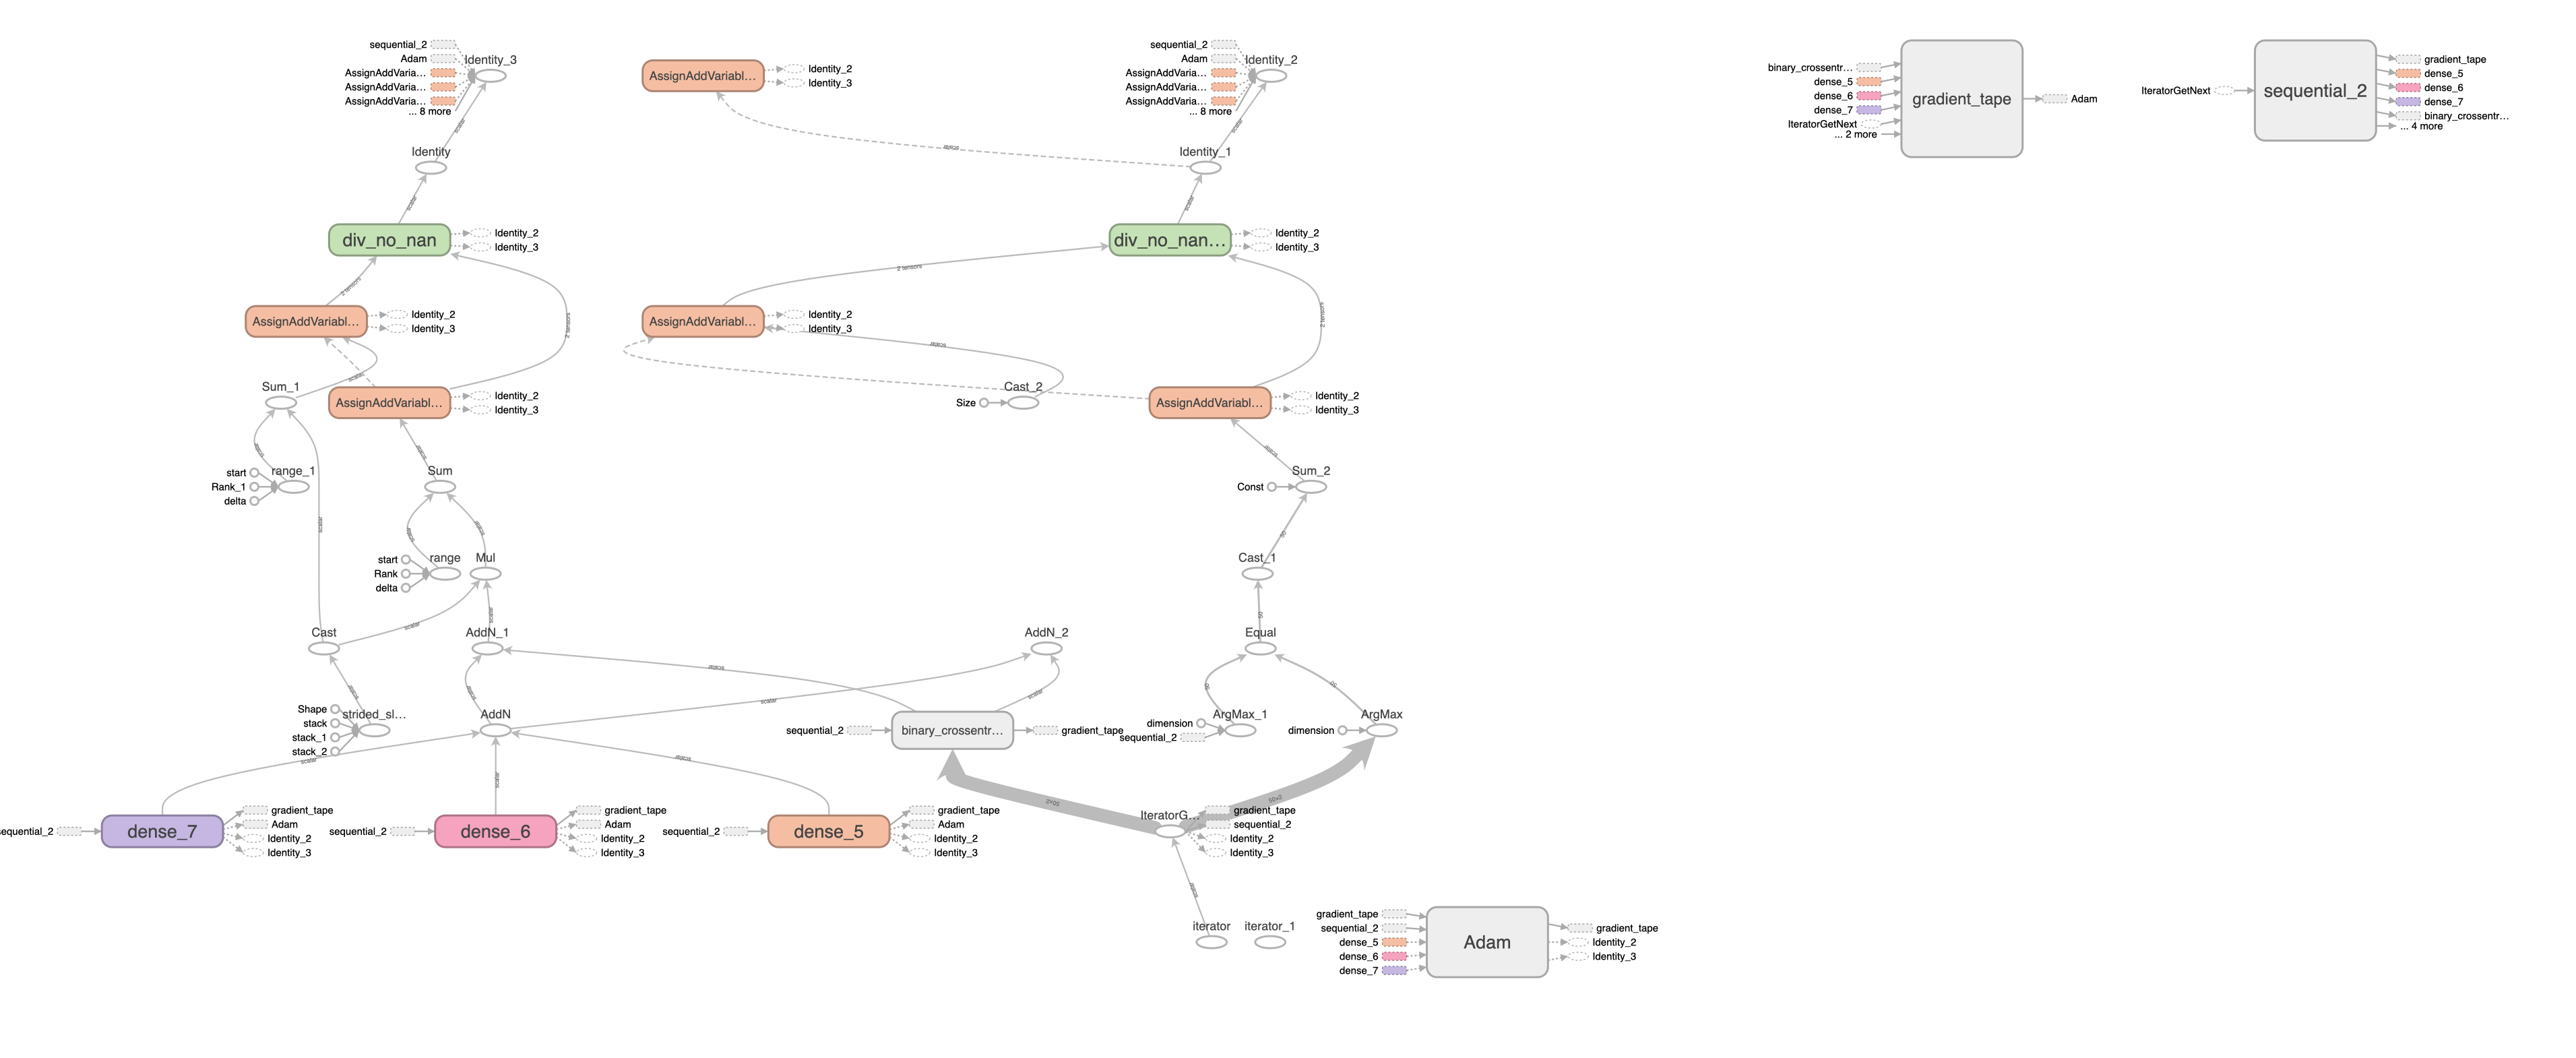

# BATCH NORMALIZATION ON CNN LAYERS WITH MATRIX

In [46]:
logdir="logs/fit/" + 'model4'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [47]:
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import SGD
# instantiate model
modelBNC = Sequential()
modelBNC.add(Conv1D(32, kernel_size=5, input_shape = (4098, 3)))
modelBNC.add(BatchNormalization())
modelBNC.add(MaxPooling1D(pool_size=(2)))
modelBNC.add(Conv1D(32, kernel_size=5))
modelBNC.add(BatchNormalization())
modelBNC.add(MaxPooling1D(pool_size=(2)))
modelBNC.add(Conv1D(64, kernel_size=3))
modelBNC.add(BatchNormalization())
modelBNC.add(MaxPooling1D(pool_size=(2)))
modelBNC.add(Dropout(0.25))
modelBNC.add(Flatten())
# we can think of this chunk as the input layer
modelBNC.add(Dense(128, ))
modelBNC.add(BatchNormalization())
modelBNC.add(Activation('relu'))
modelBNC.add(Dropout(0.5))

# we can think of this chunk as the hidden layer    
modelBNC.add(Dense(64,))
modelBNC.add(BatchNormalization())
modelBNC.add(Activation('relu'))
modelBNC.add(Dropout(0.5))

# we can think of this chunk as the output layer
modelBNC.add(Dense(1))
modelBNC.add(BatchNormalization())
modelBNC.add(Activation('sigmoid'))

# setting up the optimization of our weights 
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#modelBNC.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
modelBNC.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# running the fitting


C:\Users\VENUM\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [48]:
modelBNC.fit(final_a_ary, y_train, batch_size=50, epochs=50, verbose=1, validation_data=(final_b_ary, y_test),callbacks=[tensorboard_callback])

Epoch 1/50
29/29 [==============================] - 14s 389ms/step - loss: 0.6871 - accuracy: 0.6101 - val_loss: 2.3994 - val_accuracy: 0.3928
Epoch 2/50
29/29 [==============================] - 1s 21ms/step - loss: 0.5023 - accuracy: 0.7797 - val_loss: 0.5491 - val_accuracy: 0.7187
Epoch 3/50
29/29 [==============================] - 1s 21ms/step - loss: 0.4487 - accuracy: 0.8924 - val_loss: 0.4881 - val_accuracy: 0.8635
Epoch 4/50
29/29 [==============================] - 1s 21ms/step - loss: 0.4163 - accuracy: 0.9175 - val_loss: 0.5612 - val_accuracy: 0.6825
Epoch 5/50
29/29 [==============================] - 1s 21ms/step - loss: 0.3871 - accuracy: 0.9477 - val_loss: 0.5707 - val_accuracy: 0.6657
Epoch 6/50
29/29 [==============================] - 1s 21ms/step - loss: 0.3717 - accuracy: 0.9479 - val_loss: 0.5593 - val_accuracy: 0.6852
Epoch 7/50
29/29 [==============================] - 1s 21ms/step - loss: 0.3532 - accuracy: 0.9686 - val_loss: 0.5438 - val_accuracy: 0.6880
Epoch 8/50


In [49]:
loss, acc = modelBNC.evaluate(final_b_ary, y_test, verbose=0)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))


Testing loss: 0.23475660383701324, acc: 0.9192200303077698



In [50]:
fp = tf.keras.metrics.FalsePositives()
fp.update_state(y_test, modelBNC.predict(final_b_ary))
fn = tf.keras.metrics.FalseNegatives()
fn.update_state(y_test, modelBNC.predict(final_b_ary))
print('false positives', fp.result().numpy())
print('false negatives', fn.result().numpy())

false positives 14.0
false negatives 15.0


In [51]:
from sklearn.model_selection import StratifiedKFold
import logging

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
bigx = np.concatenate((final_a_ary,final_b_ary))
bigy = np.concatenate((y_train, y_test))
cvscores = []
tf.get_logger().setLevel(logging.ERROR)
for train, test in kfold.split(bigx, bigy):
    # create model
    modelBNC.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
    # Fit the model
    #print(train)
    modelBNC.fit(bigx[train], bigy[train], epochs=10, verbose=0)
    # evaluate the model
    scores = modelBNC.evaluate(bigx[test], bigy[test], verbose=0)
    print("%s: %.2f%%" % (modelBNC.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

    pred = modelBNC.predict(bigx[test])

    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(bigy[test], pred)
    fn = tf.keras.metrics.FalseNegatives()
    fn.update_state(bigy[test], pred)
    
    print('false positives', fp.result().numpy())
    print('false negatives', fn.result().numpy())
    print()
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


# calculate false positives and negatives based on the predicted output vs. expected output
fp = tf.keras.metrics.FalsePositives()
fp.update_state(bigy[test], pred)
fp = fp.result().numpy()
# Getting False Negative
fn = tf.keras.metrics.FalseNegatives()
fn.update_state(bigy[test], pred)
fn = fn.result().numpy()
# Getting True Negative
tn = tf.keras.metrics.TrueNegatives()
tn.update_state(bigy[test], pred)
tn = tn.result().numpy()
#Calculating True Negative 
# Find false positive rate.
fpr = fp / (fp + tn)


#calculating True Positve
tp = tf.keras.metrics.TruePositives()
tp.update_state(bigy[test], pred)
tp = tp.result().numpy()
#code for false negative 
fnr = fn / (fn + tp)


print("False Negative Rate", fnr)
print("Value of FPR", fpr)

accuracy: 98.61%
98.61% (+/- 0.00%)
false positives 1.0
false negatives 4.0

accuracy: 99.72%
99.16% (+/- 0.56%)
false positives 1.0
false negatives 0.0

accuracy: 100.00%
99.44% (+/- 0.60%)
false positives 0.0
false negatives 0.0

accuracy: 99.72%
99.51% (+/- 0.53%)
false positives 1.0
false negatives 0.0

accuracy: 99.44%
99.50% (+/- 0.48%)
false positives 2.0
false negatives 0.0

99.50% (+/- 0.48%)
False Negative Rate 0.0
Value of FPR 0.008264462


accuracy:  0.9972144846796658
precision:  0.9923076923076923
recall:  1.0
f1:  0.9961389961389961
False Negative Rate 0.0
Value of FPR 0.008264462


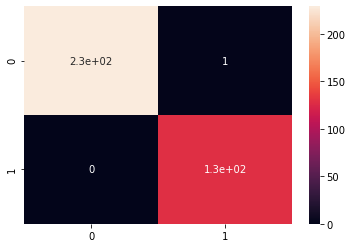

In [53]:
# Fixed: Either Fp or Tn is 0:  For Hamza : this FPR & FNR should be different than line 52

y_pred=modelBNC.predict(final_b_ary)
# y_pred_cats=y_pred.argmax(axis=1)
# y_test_cats=y_test.argmax(axis=1)
y_pred_cats=y_pred>.5
y_test_cats=y_test>.5
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score,accuracy_score
import seaborn as sns
#y_pred=modelBNrm.predict(final_b_ary)
accuracy=accuracy_score(y_test_cats,y_pred_cats)
precision=precision_score(y_test_cats,y_pred_cats)
recall=recall_score(y_test_cats,y_pred_cats)
f1=f1_score(y_test_cats,y_pred_cats)
print('accuracy: ',accuracy)
print('precision: ',precision)
print('recall: ',recall)
print('f1: ',f1)
cm=confusion_matrix(y_test_cats,y_pred_cats)
sns.heatmap(cm,annot=True)

#fp = tf.keras.metrics.FalsePositives()
#fp.update_state(y_test, modelBNC.predict(final_b_ary))
#fn = tf.keras.metrics.FalseNegatives()
#fn.update_state(y_test, modelBNC.predict(final_b_ary))
#print('false positives', fp.result().numpy())
#print('false negatives', fn.result().numpy())

# calculate false positives and negatives based on the predicted output vs. expected output
fp = tf.keras.metrics.FalsePositives()
fp.update_state(bigy[test], pred)
fp = fp.result().numpy()

# Getting False Negative
fn = tf.keras.metrics.FalseNegatives()
fn.update_state(bigy[test], pred)
fn = fn.result().numpy()

# Getting True Negative
tn = tf.keras.metrics.TrueNegatives()
tn.update_state(bigy[test], pred)
tn = tn.result().numpy()
 
# Find false positive rate.
fpr = fp / (fp + tn)


#calculating True Positve
tp = tf.keras.metrics.TruePositives()
tp.update_state(bigy[test], pred)
tp = tp.result().numpy()

#code for false negative 
fnr = fn / (fn + tp)


print("False Negative Rate", fnr)
print("Value of FPR", fpr)

In [54]:
!taskkill /im tensorboard.exe /f
!del /q %TMP%\.tensorboard-info\*

ERROR: The process "tensorboard.exe" not found.


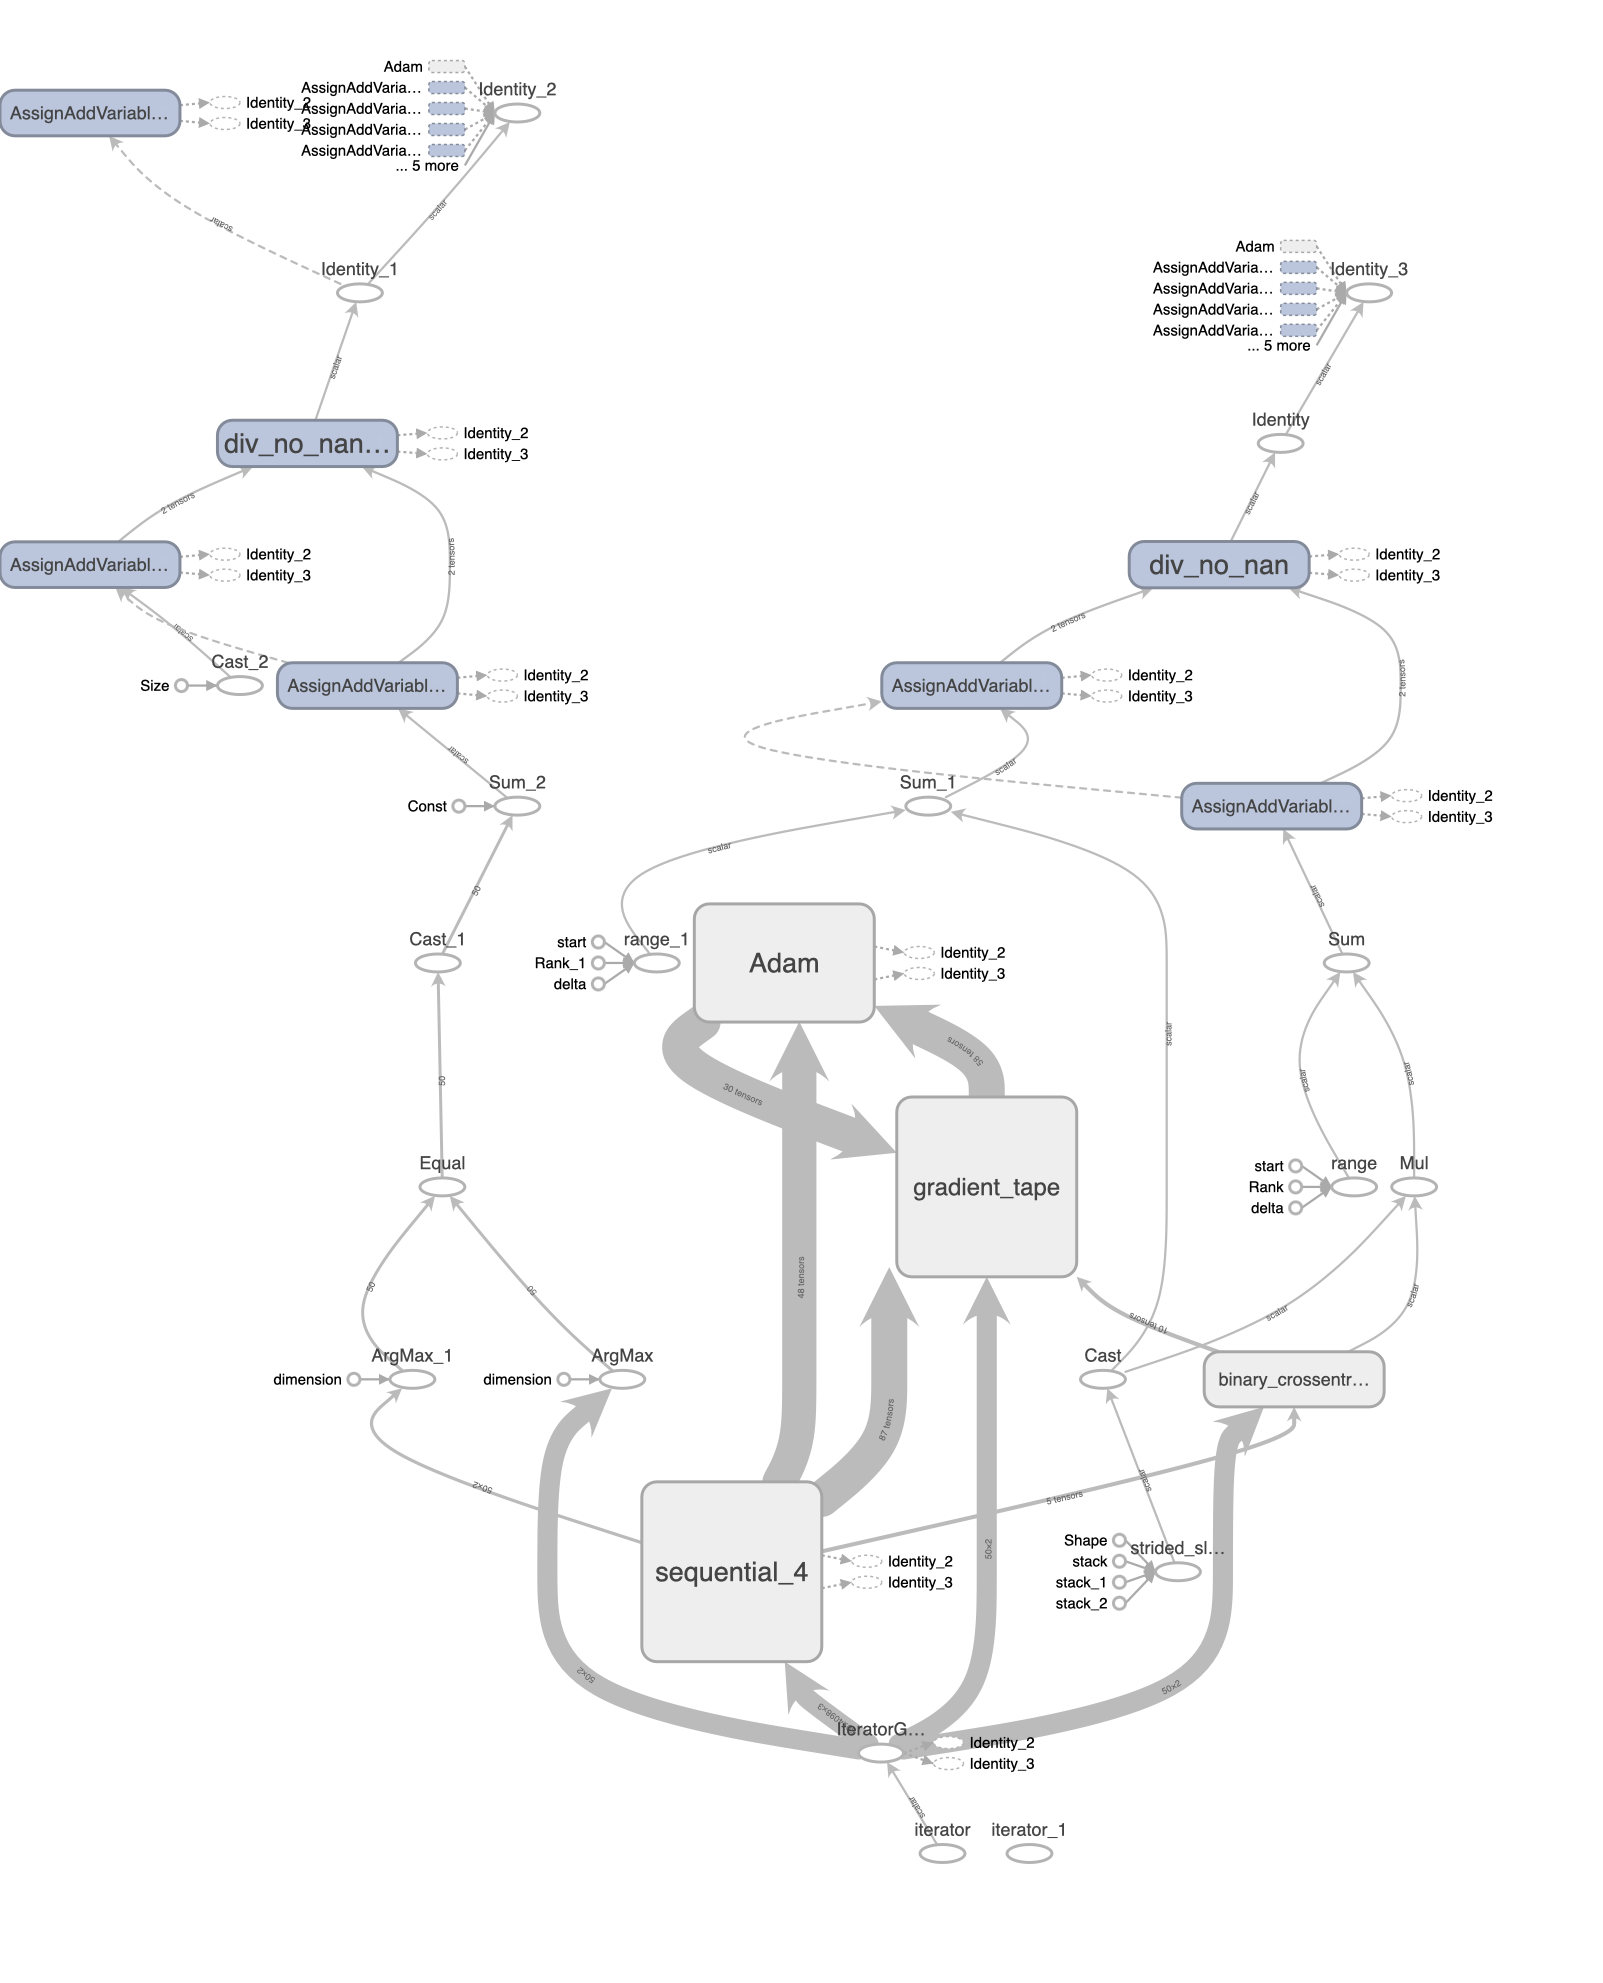

In [55]:
%load_ext tensorboard
%tensorboard --logdir logs
# !taskkill /im tensorboard.exe /f
# !del /q %TMP%\.tensorboard-info\*